In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  CWD = '/content/drive/MyDrive/DataSources/SkinCare'
  os.chdir(CWD)
except:None
G_path = './Project_Data'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
import time
import os
from statistics import mean
import pandas as pd
import sklearn as sk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *
device = None
try:
    c = torch.cuda.is_available()
    if c:
        print('devis: cuda')
        device = 'cuda'
    else:
        try :
            m = torch.backends.mps.is_available()
            if m:
                device = 'mps'
                print('devis: mps')  
        except:    
            device = 'cpu'
            print('devis: cpu')           
except:
    None

devis: mps


# **Import DataSets**

In [3]:
file = 'Input_DataSet_280x210' 
input_data , labels = pickle.load(open(G_path + '/06_Rescaled_DataSet/'+ file,'rb'))
labels_biary = labels[1]
labels_multi = labels[0]

file = 'Input_DataSet_A_E' 
A_E_input_data , A_E_labels = pickle.load(open(G_path + '/05_AutoEncoded_DataSet/'+ file,'rb'))
A_E_labels_biary = A_E_labels[1]
A_E_labels_multi = A_E_labels[0]

file = 'Balanced_Test_Set_280x210' 
BLC_test_280x210 = pickle.load(open(G_path + '/06_Rescaled_DataSet/' + file,'rb'))

file = 'Balanced_Test_Set_A_E' 
BLC_test_A_E = pickle.load(open(G_path + '/05_AutoEncoded_DataSet/' + file,'rb'))

Meta_Data_Augmented = pickle.load(open( G_path + '/02_Augmented_MetaData/Meta_Data_Augmented','rb'))

# **Import Model**

In [4]:
C_280 = 'CNN_280x210_MultiClassModel0_24_Jun22_22-38' # Best of grid search ['CNN_280x210_Model5_23_Jun22_12-55','CNN_280x210_Model4_22_Jun22_00-14]
C_280_binary = 'CNN_280x210_Binary_24_Jun22_22-17'

Model_280x210_multi = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/'+ C_280 , 'rb') ).eval()
Model_280x210_binary = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/'+ C_280_binary , 'rb') ).eval()

A_E = 'A_E_CNN_Model6_22_Jun22_00-29' #Best of grid search
A_E_binary = 'A_E_CNN_Model0_25_Jun22_09-35'
# [CNN_Nets.Net8_a, Model_Training_with_loader] = pickle.load(open(G_Models+'/Net8_Model_Trainin','rb'))
Model_A_En_multiclass = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' + A_E , 'rb') ).eval()
Model_A_En_binary = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' + A_E_binary , 'rb') ).eval()

# **Model Evaluation**

Nr. of Data : 
 407
Accuracy of The Model : 
 0.6535626535626535


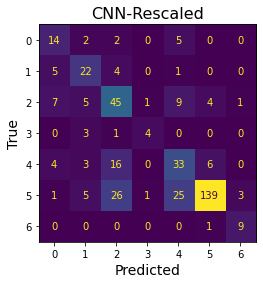

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,45.2%,60.9%,95.6%,51.9%
1,7.9%,55.0%,68.8%,95.2%,61.1%
2,17.7%,47.9%,62.5%,85.4%,54.2%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,45.2%,53.2%,88.4%,48.9%
5,49.1%,92.7%,69.5%,94.7%,79.4%
6,2.5%,69.2%,90.0%,99.0%,78.3%
Simple Avg.,nan%,60.3%,65.0%,94.0%,61.6%
Weighted Avg.,nan%,70.8%,65.4%,92.4%,66.9%


In [23]:
# Model 280x210
binary = False
if binary:
    model_ = Model_280x210_binary
    Y = labels_biary[2]
else:
    model_ = Model_280x210_multi
    Y = labels_multi[2]
X = input_data[2]
# X = BLC_test_280x210[0]
# Y = BLC_test_280x210[1]
iter = X.shape[0] // 100
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*100:(i+1)*100]
    Y_ = model_.forward_noDrop(X_).argmax(dim=1)
    Y_pred = torch.cat([Y_pred,Y_])

Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
# results = model_evaluation(Y_binary,Y_pred_binary)
results = model_evaluation(Y,Y_pred,'CNN-Rescaled')
results

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Nr. of Data : 
 407
Accuracy of The Model : 
 0.7272727272727273


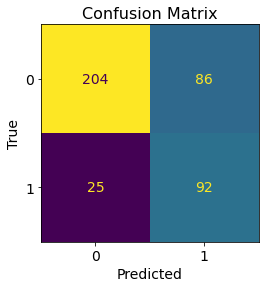

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,89.1%,70.3%,78.6%,78.6%
1,28.7%,51.7%,78.6%,70.3%,62.4%
Simple Avg.,nan%,70.4%,74.5%,74.5%,70.5%
Weighted Avg.,nan%,78.3%,72.7%,76.3%,73.9%


In [24]:
# Model AutoEncoder
binary = False
if binary:
    model_ = Model_A_En_binary
    Y = A_E_labels_biary[2]
else:
    model_ = Model_A_En_multiclass
    Y = A_E_labels_multi[2]
    
X = A_E_input_data[2]
# X = BLC_test_A_E[0]
# Y = BLC_test_A_E[1]
iter = X.shape[0] // 100
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*100:(i+1)*100]
    Y_ = model_.forward_noDrop(X_).argmax(dim=1)
    Y_pred = torch.cat([Y_pred,Y_])
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
# results = model_evaluation(Y,Y_pred)
results = model_evaluation(Y_binary,Y_pred_binary)
results

# **CNN: 280x210 MultiClass: Get CNN OutPut (Soft-Max)**

In [5]:

model_ = Model_280x210_multi
X = torch.cat([input_data[0],input_data[1],input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    # Y_ = model_.forward_noDrop(X_).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 280, 210]), torch.Size([4647, 7]))

In [6]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([input_data[3][0],input_data[3][1],input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_280x210_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [17]:
CNN_280x210_data.sample(100).drop(columns=['lesion_id','dx']).style.format({'CNN_0': "{:.1%}",'CNN_1': "{:.1%}",'CNN_2': "{:.1%}",'CNN_3': "{:.1%}",'CNN_4': "{:.1%}",'CNN_5': "{:.1%}",'CNN_6': "{:.1%}",'age': "{:0}"})

,type,image_id,CNN_0,CNN_1,CNN_2,CNN_3,CNN_4,CNN_5,CNN_6,dx_type,age,sex,localization,label_description,image_label,binary_label
4414,test,ISIC_0028254,14.2%,5.2%,35.9%,0.0%,38.8%,5.9%,0.0%,histo,70.0,female,chest,keratosis-like,2,0
3212,train,ISIC_0026163,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,histo,50.0,female,hand,vascular,6,0
3693,train,AUG_ISIC_0030687,0.0%,37.2%,56.7%,0.0%,4.2%,2.0%,0.0%,histo,80.0,male,scalp,basal cell carcinoma,1,1
4252,test,ISIC_0027511,0.0%,0.0%,0.6%,0.0%,0.1%,99.3%,0.0%,follow_up,50.0,male,lower extremity,melanocytic nevi,5,0
4071,valid,ISIC_0030602,42.9%,8.0%,11.2%,0.5%,35.7%,1.7%,0.0%,histo,60.0,male,upper extremity,Actinic keratoses,0,1
2865,train,ISIC_0027478,2.9%,87.1%,3.2%,0.0%,4.8%,2.0%,0.0%,histo,40.0,male,back,basal cell carcinoma,1,1
1191,train,AUG_ISIC_0030953,85.9%,5.0%,3.9%,3.3%,1.8%,0.1%,0.0%,histo,80.0,female,upper extremity,Actinic keratoses,0,1
3226,train,ISIC_0033546,0.0%,0.0%,0.9%,0.0%,62.1%,36.9%,0.0%,histo,40.0,female,back,melanoma,4,1
2470,train,ISIC_0029587,0.0%,0.0%,2.3%,0.0%,0.5%,97.3%,0.0%,follow_up,75.0,female,back,melanocytic nevi,5,0
1622,train,ISIC_0031539,8.8%,29.4%,20.8%,0.3%,33.7%,7.0%,0.0%,histo,75.0,male,back,basal cell carcinoma,1,1


In [27]:
cols = ['localization','sex','dx_type']
CNN_280x210_data_encoded = pd.get_dummies(CNN_280x210_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_280x210_data_encoded_STD = standardizaion(CNN_280x210_data_encoded,'age')

In [28]:
pickle.dump(CNN_280x210_data_encoded_STD, open(G_path + '/07_CNNs_Output_DataSet/'+ 'CNN_280x210_Ouput_MultiClass', 'wb'))

# **CNN: 280x210 Binary**

In [29]:

model_ = Model_280x210_binary
X = torch.cat([input_data[0],input_data[1],input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 280, 210]), torch.Size([4647, 2]))

In [30]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([input_data[3][0],input_data[3][1],input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_280x210_data_binary = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [31]:
CNN_280x210_data_binary[:2]

,type,image_id,CNN_0,CNN_1,lesion_id,dx,dx_type,age,sex,localization,image_label,binary_label
0,train,ISIC_0032929,0.457048,0.542952,HAM_0003321,bkl,histo,75.0,female,face,2,0
1,train,ISIC_0026790,0.875181,0.124819,HAM_0005779,bkl,consensus,55.0,male,back,2,0


In [32]:
cols = ['localization','sex','dx_type']
CNN_280x210_data_binary_encoded = pd.get_dummies(CNN_280x210_data_binary, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_280x210_data_binary_encoded_STD = standardizaion(CNN_280x210_data_binary_encoded,'age')

In [33]:
pickle.dump(CNN_280x210_data_binary_encoded_STD, open(G_path + '/07_CNNs_Output_DataSet/'+ 'CNN_280x210_Ouput_binary', 'wb'))

# **CNN: AutoEncoder, Get CNN OutPut (Soft-Max)**

In [34]:
model_ = Model_A_En_multiclass
X = torch.cat([A_E_input_data[0],A_E_input_data[1],A_E_input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 282, 207]), torch.Size([4647, 7]))

In [35]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([A_E_input_data[3][0],A_E_input_data[3][1],A_E_input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_A_E_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [36]:
cols = ['localization','sex','dx_type']
CNN_A_E_data_encoded = pd.get_dummies(CNN_A_E_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_A_E_data_encoded_STD = standardizaion(CNN_A_E_data_encoded,'age')

In [37]:
pickle.dump(CNN_A_E_data_encoded_STD, open(G_path + '/07_CNNs_Output_DataSet/'+ 'CNN_A_E_Ouput_MultiClass', 'wb'))

# **CNN: AutoEncoder Binary, Output**

In [38]:
model_ = Model_A_En_binary
X = torch.cat([A_E_input_data[0],A_E_input_data[1],A_E_input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 282, 207]), torch.Size([4647, 2]))

In [39]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([A_E_input_data[3][0],A_E_input_data[3][1],A_E_input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_A_E_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [40]:
cols = ['localization','sex','dx_type']
CNN_A_E_data_encoded = pd.get_dummies(CNN_A_E_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_A_E_data_encoded_STD = standardizaion(CNN_A_E_data_encoded,'age')

In [41]:
pickle.dump(CNN_A_E_data_encoded_STD, open(G_path + '/07_CNNs_Output_DataSet/'+ 'CNN_A_E_Ouput_Binary', 'wb'))